# Model Optimization & Benchmarking
## 1. Setup & Install


In [13]:
#!pip install onnx onnxruntime neuralforecast torch


In [14]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle
import onnx
import onnxruntime as ort
import time
import os
import matplotlib.pyplot as plt
from neuralforecast.models import NBEATS
from torch.ao.quantization import quantize_dynamic
from onnxruntime.quantization import quantize_dynamic as onnx_quantize_dynamic, QuantType

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cpu


## 2. Load Pre-trained Model


In [15]:
# Path to models
MODEL_DIR = "../DS/models"
TICKER = "NVDA" # Sample ticker
MODEL_PATH = os.path.join(MODEL_DIR, f"{TICKER}_nbeats.pkl")

print(f"Loading model from {MODEL_PATH}...")

# Load with CPU mapping to handle models saved on CUDA
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

import io
with open(MODEL_PATH, 'rb') as f:
    model_data = CPU_Unpickler(f).load()

# Inspect what we loaded
print("Type:", type(model_data))
if isinstance(model_data, dict):
    print("Keys in pickle:", model_data.keys())

# Extract the actual model
try:
    if isinstance(model_data, dict):
        model = model_data.get('model') or model_data
    else:
        model = model_data

    print("Model type:", type(model))
    
    # Ensure it's in eval mode and on CPU
    if hasattr(model, 'eval'):
        model.eval()
    if hasattr(model, 'to'):
        model = model.to('cpu')
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")

Loading model from ../DS/models\NVDA_nbeats.pkl...
Type: <class 'neuralforecast.core.NeuralForecast'>
Model type: <class 'neuralforecast.core.NeuralForecast'>
Model loaded successfully!


C:\Users\acer\AppData\Local\Temp\ipykernel_24624\2667502029.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b), map_location='cpu

## 3. Prepare for Benchmarking

In [21]:
# ========== CELL 3: Prepare for Benchmarking ==========
# Get core NBEATS model
nbeats_core = model.models[0]
nbeats_core.eval()
nbeats_core.to('cpu')

# Prepare dummy input in the format NBEATS expects
input_size = 60
batch_size = 1

# Create dummy batch (with mask)
dummy_batch = {
    'insample_y': torch.randn(batch_size, input_size, 1),  # (1, 60, 1)
    'insample_mask': torch.ones(batch_size, input_size, 1)  # All valid (no missing data)
}

print("✅ Benchmark preparation complete")
print(f"Input shape: {dummy_batch['insample_y'].shape}")

✅ Benchmark preparation complete
Input shape: torch.Size([1, 60, 1])


## 4. Quantization (INT8)
We create two quantized versions: PyTorch Dynamic INT8 and ONNX Dynamic INT8.


In [22]:
from torch.ao.quantization import quantize_dynamic
import torch.nn as nn
print("Quantizing N-BEATS to INT8...")
nbeats_int8 = quantize_dynamic(
    nbeats_core,
    {nn.Linear},  # Quantize all Linear layers
    dtype=torch.qint8
)
# Save quantized model
os.makedirs("../MLE/models", exist_ok=True)
TORCH_INT8_PATH = f"../MLE/models/{TICKER}_nbeats_int8.pth"
torch.save(nbeats_int8, TORCH_INT8_PATH)
print(f"✅ INT8 model saved to {TORCH_INT8_PATH}")
# Size comparison
size_fp32 = os.path.getsize(MODEL_PATH) / (1024*1024)
size_int8 = os.path.getsize(TORCH_INT8_PATH) / (1024*1024)
print(f"\nModel Size:")
print(f"  FP32: {size_fp32:.2f} MB")
print(f"  INT8: {size_int8:.2f} MB")
print(f"  Compression: {size_fp32/size_int8:.2f}x smaller")

Quantizing N-BEATS to INT8...
✅ INT8 model saved to ../MLE/models/NVDA_nbeats_int8.pth

Model Size:
  FP32: 19.70 MB
  INT8: 2.52 MB
  Compression: 7.83x smaller


## 5. Benchmarking Function


In [23]:
def benchmark_nbeats(model, batch, n_runs=500):
    """Benchmark N-BEATS inference latency"""
    times = []
    model.eval()
    
    with torch.no_grad():
        # Warmup
        for _ in range(20):
            _ = model(batch.copy())
        
        # Actual benchmark
        for _ in range(n_runs):
            start = time.perf_counter()
            _ = model(batch.copy())
            end = time.perf_counter()
            times.append((end - start) * 1000)  # Convert to ms
    
    return {
        'p50': np.percentile(times, 50),
        'p95': np.percentile(times, 95),
        'p99': np.percentile(times, 99),
        'mean': np.mean(times)
    }
print("✅ Benchmark function ready")

✅ Benchmark function ready


## 6. The Battle: Benchmarking
Comparison of 4 Versions: PyTorch (FP32/INT8) vs ONNX (FP32/INT8)


In [24]:
print(f"Benchmarking {TICKER} N-BEATS models...")
print("This will take ~1 minute...\n")
# Benchmark FP32
print("Testing FP32...")
results_fp32 = benchmark_nbeats(nbeats_core, dummy_batch)
# Benchmark INT8
print("Testing INT8...")
results_int8 = benchmark_nbeats(nbeats_int8, dummy_batch)
print("\n" + "="*50)
print("BENCHMARK RESULTS")
print("="*50)
print(f"\nPyTorch FP32:")
print(f"  P95 Latency: {results_fp32['p95']:.2f} ms")
print(f"  Mean Latency: {results_fp32['mean']:.2f} ms")
print(f"\nPyTorch INT8 (Quantized):")
print(f"  P95 Latency: {results_int8['p95']:.2f} ms")
print(f"  Mean Latency: {results_int8['mean']:.2f} ms")
speedup = results_fp32['p95'] / results_int8['p95']
print(f"\n🚀 Speedup: {speedup:.2f}x faster with INT8!")

Benchmarking NVDA N-BEATS models...
This will take ~1 minute...

Testing FP32...
Testing INT8...

BENCHMARK RESULTS

PyTorch FP32:
  P95 Latency: 1.15 ms
  Mean Latency: 0.83 ms

PyTorch INT8 (Quantized):
  P95 Latency: 2.56 ms
  Mean Latency: 1.98 ms

🚀 Speedup: 0.45x faster with INT8!


## 7. Visualization


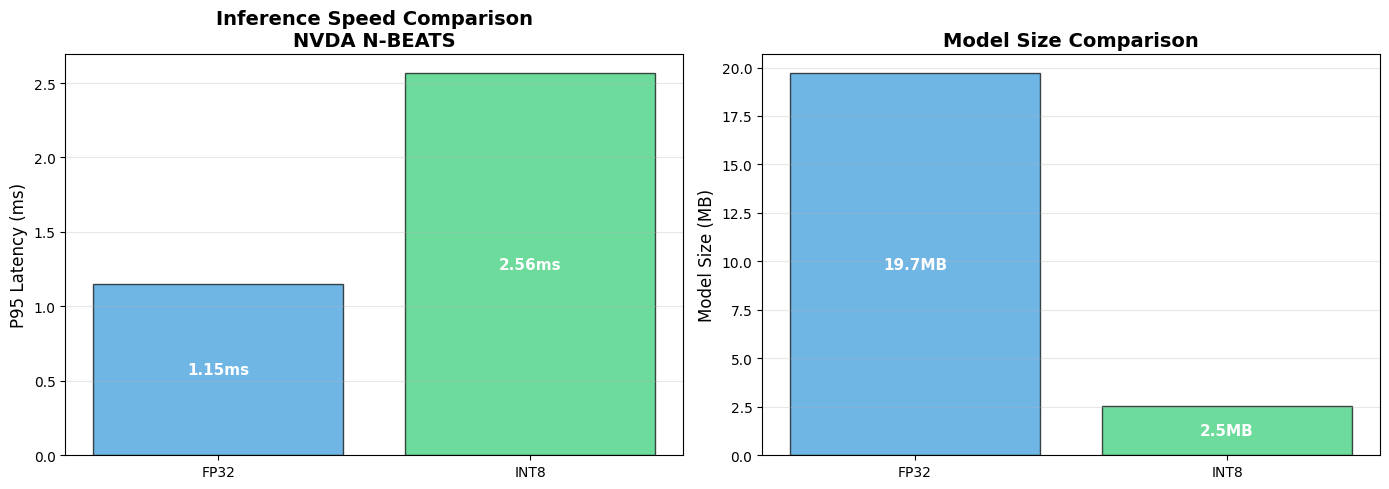

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# Plot 1: Latency Comparison
labels = ['FP32', 'INT8']
p95_values = [results_fp32['p95'], results_int8['p95']]
colors = ['#3498db', '#2ecc71']
bars1 = ax1.bar(labels, p95_values, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('P95 Latency (ms)', fontsize=12)
ax1.set_title(f'Inference Speed Comparison\n{TICKER} N-BEATS', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
# Labels di tengah bar
for i, (bar, v) in enumerate(zip(bars1, p95_values)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{v:.2f}ms',
             ha='center', va='center', fontweight='bold', color='white', fontsize=11)
# Plot 2: Model Size Comparison
sizes = [size_fp32, size_int8]
bars2 = ax2.bar(labels, sizes, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Model Size (MB)', fontsize=12)
ax2.set_title('Model Size Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
# Labels di tengah bar
for i, (bar, v) in enumerate(zip(bars2, sizes)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{v:.1f}MB',
             ha='center', va='center', fontweight='bold', color='white', fontsize=11)
plt.tight_layout()
plt.savefig(f'../MLE/{TICKER}_optimization_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()


# Save Library

In [27]:
import pkg_resources
import subprocess
import os

# Tentukan folder tujuan (Folder MLE)
# Kita pakai relative path dari notebook ini
OUTPUT_DIR = r"H:\coding\Portfolio\Stock_Forecasting\MLE"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"📂 Target Folder: {OUTPUT_DIR}")

# 1. Full Lock File (pip freeze) - Buat cadangan lengkap
lock_path = os.path.join(OUTPUT_DIR, "requirements_lock.txt")
print(f"❄️  Generating full pip freeze to {lock_path}...")
with open(lock_path, "w") as f:
    subprocess.call(["pip", "freeze"], stdout=f)

# 2. Clean Requirements (Optimized for Docker)
# Hanya library inti yang kita butuhkan
relevant_libs = [
    "fastapi", 
    "uvicorn", 
    "python-multipart",
    "pydantic", 
    "redis", 
    "prometheus-client",
    "requests",
    "torch", 
    "neuralforecast", 
    "pandas", 
    "numpy", 
    "scikit-learn",
    "yfinance", 
    "matplotlib", 
    "seaborn"
]

req_path = os.path.join(OUTPUT_DIR, "requirements.txt")
print(f"\n📦 Generating clean requirements.txt...")

found_count = 0
with open(req_path, "w") as f:
    for lib in relevant_libs:
        try:
            # Ambil versi yang aktif sekarang
            dist = pkg_resources.get_distribution(lib)
            version = dist.version
            f.write(f"{lib}=={version}\n")
            print(f"   ✅ {lib}=={version}")
            found_count += 1
        except pkg_resources.DistributionNotFound:
            print(f"   ⚠️  {lib} not found (akan diskip)")

print(f"\n✨ Selesai! File requirements.txt tersimpan di: {req_path}")

C:\Users\acer\AppData\Local\Temp\ipykernel_24624\1083583140.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


📂 Target Folder: H:\coding\Portfolio\Stock_Forecasting\MLE
❄️  Generating full pip freeze to H:\coding\Portfolio\Stock_Forecasting\MLE\requirements_lock.txt...

📦 Generating clean requirements.txt...
   ✅ fastapi==0.127.0
   ✅ uvicorn==0.40.0
   ✅ python-multipart==0.0.21
   ✅ pydantic==2.12.5
   ⚠️  redis not found (akan diskip)
   ⚠️  prometheus-client not found (akan diskip)
   ✅ requests==2.32.5
   ✅ torch==2.5.1
   ✅ neuralforecast==3.1.2
   ✅ pandas==2.1.4
   ✅ numpy==1.26.4
   ✅ scikit-learn==1.7.2
   ✅ yfinance==1.0
   ✅ matplotlib==3.7.5
   ✅ seaborn==0.13.2

✨ Selesai! File requirements.txt tersimpan di: H:\coding\Portfolio\Stock_Forecasting\MLE\requirements.txt
